In [5]:
from __future__ import print_function
import steps.model as smodel
import steps.solver as ssolver
import steps.geom as swm
import steps.rng as srng

from parameters import *
from misc import *
from components import *

In [6]:
def get_VDCC(ssys, mdl, Ca):    
    vdccMol = {}
    for mol in vdccMolName:
        vdccMol.update({mol: smodel.Spec(mol, mdl)})

    # Temporarily
    kpq_a1 = 1
    kpq_b1 = 1
    kpq_a2 = 1
    kpq_b2 = 1
    kpq_a3 = 1
    kpq_b3 = 1
    kpq_a4 = 1
    kpq_b4 = 1
    kVDCCflux = 100

    R_VDCC = {}
    R_VDCC['VDCC_C01'] = smodel.VDepSReac('R_VDCC_C01', ssys, slhs=[vdccMol['VDCC_C0']], srhs=[vdccMol['VDCC_C1']], 
                                          k=lambda V: 1.0e3 *4.*pq_a1(V*1.0e3))
    R_VDCC['VDCC_C10'] = smodel.VDepSReac('R_VDCC_C10', ssys, slhs=[vdccMol['VDCC_C1']], srhs=[vdccMol['VDCC_C0']], 
                                          k=lambda V: 1.0e3 *4.*pq_b1(V*1.0e3))
    R_VDCC['VDCC_C12'] = smodel.VDepSReac('R_VDCC_C12', ssys, slhs=[vdccMol['VDCC_C1']], srhs=[vdccMol['VDCC_C2']], 
                                          k=lambda V: 1.0e3 *4.*pq_a2(V*1.0e3))
    R_VDCC['VDCC_C21'] = smodel.VDepSReac('R_VDCC_C21', ssys, slhs=[vdccMol['VDCC_C2']], srhs=[vdccMol['VDCC_C1']], 
                                          k=lambda V: 1.0e3 *4.*pq_b2(V*1.0e3))
    R_VDCC['VDCC_C23'] = smodel.VDepSReac('R_VDCC_C23', ssys, slhs=[vdccMol['VDCC_C2']], srhs=[vdccMol['VDCC_C3']], 
                                          k=lambda V: 1.0e3 *4.*pq_a3(V*1.0e3))
    R_VDCC['VDCC_C32'] = smodel.VDepSReac('R_VDCC_C32', ssys, slhs=[vdccMol['VDCC_C3']], srhs=[vdccMol['VDCC_C2']], 
                                          k=lambda V: 1.0e3 *4.*pq_b3(V*1.0e3))
    R_VDCC['VDCC_C3O'] = smodel.VDepSReac('R_VDCC_C3O', ssys, slhs=[vdccMol['VDCC_C3']], srhs=[vdccMol['VDCC_O']],  
                                          k=lambda V: 1.0e3 *4.*pq_a4(V*1.0e3))
    R_VDCC['VDCC_OC3'] = smodel.VDepSReac('R_VDCC_OC3', ssys, slhs=[vdccMol['VDCC_O']],  srhs=[vdccMol['VDCC_C3']], 
                                          k=lambda V: 1.0e3 *4.*pq_b4(V*1.0e3))
    R_VDCC['VDCCflux'] = smodel.VDepSReac('R_VDCCflux', ssys, slhs=[vdccMol['VDCC_O']],  srhs=[vdccMol['VDCC_O']], irhs=[Ca], 
                                          k=lambda V: 1)
    
    return vdccMol, R_VDCC

In [7]:
mParts = ['vdcc']#, 'az', 'cb', 'pmca', 'ryr']

mdl = smodel.Model()
##cytvsys = smodel.Volsys('cytvsys', mdl)
cytssys = smodel.Surfsys('cytSurfsys', mdl)

##ervsys = smodel.Volsys('ervsys', mdl)
erssys = smodel.Surfsys('erSurfsys', mdl)

Ca = smodel.Spec('Ca', mdl)

if 'cb'    in mParts: cbMol,    R_cb    = get_cb(cytvsys, mdl, Ca)
if 'pmca'  in mParts: pmcaMol,  R_PMCA  = get_PMCA(cytssys, mdl, Ca)
if 'vdcc'  in mParts: vdccMol,  R_VDCC  = get_VDCC(cytssys, mdl, Ca)
if 'az'    in mParts: azMol,    R_AZ    = get_AZ(cytssys, mdl, Ca)
if 'serca' in mParts: sercaMol, R_SERCA = get_SERCA(erssys, mdl, Ca)
if 'ryr'   in mParts: ryrMol,   R_RyR   = get_RyR(erssys, mdl, Ca)

In [8]:
wmgeom = swm.Geom()

# Create the cytosol compartment
cytVol = swm.Comp('cytVol', wmgeom, vol=cytVolVal) # cyt vol = 1 - ER vol = 0.961 um^3
#cytVol.addVolsys('cytvsys')

# cyt is the 'inner' compartment, no outer compartment
cytSurf = swm.Patch('cytSurf', wmgeom, cytVol, area=cytArea) # cyt surf area = 8.5 um^2
cytSurf.addSurfsys('cytSurfsys')

# Create the Endoplasmic Reticulum compartment
#erVol = swm.Comp('erVol', wmgeom, vol=erVolVal) # ER vol = 0.039 um^3
#erVol.addVolsys('ervsys')

# # ER is the 'inner' compartment, cyt is the 'outer' compartment
#erSurf = swm.Patch('erSurf', wmgeom, erVol, cytVol, area=erArea) # ER surf area = 1.58 um^2
#erSurf.addSurfsys('erSurfsys')

#print('Inner compartment to cytSurf is', erSurf.getIComp().getID())
#print('Outer compartment to cytSurf  is', erSurf.getOComp().getID())

r = srng.create('mt19937', 256)
r.initialize(23411)

sim = ssolver.Wmdirect(mdl, wmgeom, r)
sim.reset()

In [9]:
sim.reset()

### Simulation time
ti, tf, dt = 0.0, 100.0e-3, 1e-5
T = np.arange(ti, tf+dt, dt)
npts = len(T)

### Set initial conditions
sim.setCompConc('cytVol', 'Ca', 1e-4) #initV['Ca'][0])

if 'cb' in mParts: 
    for mol,ic in zip(cbMolName,initV['cb']):
        sim.setCompConc('cytVol', mol, ic)
    
if 'pmca' in mParts: 
    for mol,ic in zip(pmcaMolName,initV['PMCA']):
        num = round(ic*8.5)
        sim.setPatchCount('cytSurf', mol, num)
    
if 'vdcc' in mParts: 
    sim.setPatchCount('cytSurf', 'VDCC_C0', 80)

if 'az' in mParts: 
    sim.setPatchCount('cytSurf', 'AZ00', 7)
    
if 'ryr' in mParts: 
    sim.setPatchCount('erSurf', 'RyRLC1', 150)


### result container
resCa = np.zeros([npts])
if 'cb'   in mParts: rescb   = np.zeros([npts, len(cbMolName)])
if 'pmca' in mParts: resPMCA = np.zeros([npts, len(pmcaMolName)])
if 'vdcc' in mParts: resVDCC = np.zeros([npts, len(vdccMolName)])
if 'az'   in mParts: resAZ   = np.zeros([npts, len(azMolName)])
if 'ryr'  in mParts: resRyR  = np.zeros([npts, len(ryrMolName)])

Ti = time()
for t in range(npts):
    sim.run(T[t])
    
    resCa[t] = sim.getCompCount('cytVol', 'Ca')
    
    if 'cb' in mParts: 
        for i,mol in enumerate(cbMolName):
            rescb[t,i] = sim.getCompCount('cytVol', mol)
        
    if 'pmca' in mParts: 
        for i,mol in enumerate(pmcaMolName):
            resPMCA[t,i] = sim.getPatchCount('cytSurf', mol)

    if 'vdcc' in mParts: 
        for i,mol in enumerate(vdccMolName):
            resVDCC[t,i] = sim.getPatchCount('cytSurf', mol)
    
    if 'az' in mParts: 
        for i,mol in enumerate(azMolName):
            resAZ[t,i] = sim.getPatchCount('cytSurf', mol)
            
    if 'ryr' in mParts: 
        for i,mol in enumerate(ryrMolName):
            resRyR[t,i] = sim.getPatchCount('erSurf', mol)
    
Tf = time()
print(Tf-Ti, 'sec')

0.04830479621887207 sec


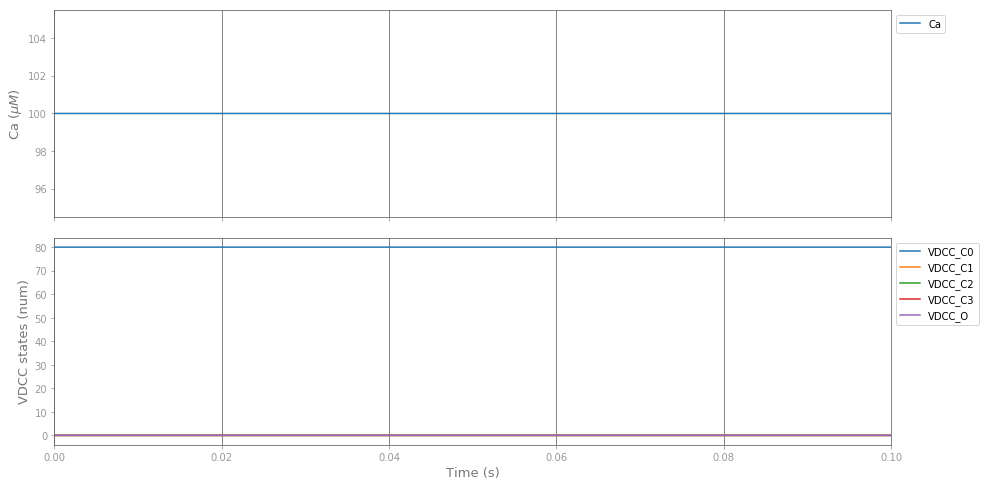

In [6]:
nFig = 1 + len(mParts)
figure, ax = plt.subplots(nFig, figsize=(15, 4*nFig), sharex=True)
figure.subplots_adjust(hspace=0.1)
labelfontsize = 13

j = 0
ax[j].plot(T, resCa/NA/cytVolVal*1e3, label='Ca')
ax[j].set_ylabel(r'Ca ($\mu M$)', fontsize=labelfontsize)

j += 1
if 'cb' in mParts: 
    for i,mol in enumerate(cbMolName):
        ax[j].plot(T, rescb[:,i], label=mol)
    ax[j].set_ylabel('Calbindin states (num)', fontsize=labelfontsize)
    j += 1

if 'pmca' in mParts:
    for i,mol in enumerate(pmcaMolName):
        ax[j].plot(T, resPMCA[:,i], label=mol)
    ax[j].set_ylabel('PMCA states (num)', fontsize=labelfontsize)
    j += 1

if 'vdcc' in mParts: 
    for i,mol in enumerate(vdccMolName):
        ax[j].plot(T, resVDCC[:,i], label=mol)
    ax[j].set_ylabel('VDCC states (num)', fontsize=labelfontsize)
    j += 1

if 'az' in mParts:
    for mol in [azMolName[i] for i in [0,5,11,12,13,14,15,16,17]]:
        i = azMolName.index(mol)
        ax[j].plot(T, resAZ[:,i], label=mol)
    ax[j].set_ylabel('AZ states (num)', fontsize=labelfontsize)
    j += 1
    
if 'ryr' in mParts:
    for i,mol in enumerate(ryrMolName):
        ax[j].plot(T, resRyR[:,i], label=mol)
    ax[j].set_ylabel('RyR states (num)', fontsize=labelfontsize)
    j += 1

ax[-1].set_xlabel('Time (s)', fontsize=labelfontsize)

facecol = '#ffffff11'
labelcol = '#777777'
tickcol = '#999999'
spinecol = '#666666'
for x in ax:
    x.legend(loc='upper left', facecolor='white', framealpha=0.8, bbox_to_anchor=(1,1))
    
    x.set_xlim(min(T), max(T))
    
    x.spines['bottom'].set_color(spinecol)
    x.spines['top'].set_color(spinecol)
    x.spines['right'].set_color(spinecol)
    x.spines['left'].set_color(spinecol)
    
    x.xaxis.label.set_color(labelcol)
    x.yaxis.label.set_color(labelcol)
    
    x.tick_params(axis='x', colors=tickcol)
    x.tick_params(axis='y', colors=tickcol)
    
    x.set_facecolor(facecol)#'xkcd:salmon')
    
    x.grid(axis='x', color=spinecol)
    
#plt.savefig('test.eps', dpi=300, format='eps', transparent=True, bbox_inches=None, pad_inches=0.1)
#plt.show()

In [3]:
### Calbindin
def get_cb(vsys):
    cbMol = {}
    for mol in cbMolName:
        cbMol.update({mol: smodel.Spec(mol, mdl)})
        
    R_cb = {}
    R_cb['cb0010'] = smodel.Reac('R_cb0010', cytvsys, lhs=[cbMol['H0M0'], Ca], rhs=[cbMol['H1M0']], kcst=2*cbHon)
    R_cb['cb1000'] = smodel.Reac('R_cb1000', cytvsys, lhs=[cbMol['H1M0']], rhs=[cbMol['H0M0'], Ca], kcst=cbHoff)
    R_cb['cb1020'] = smodel.Reac('R_cb1020', cytvsys, lhs=[cbMol['H1M0'], Ca], rhs=[cbMol['H2M0']], kcst=cbHon)
    R_cb['cb2010'] = smodel.Reac('R_cb2010', cytvsys, lhs=[cbMol['H2M0']], rhs=[cbMol['H1M0'], Ca], kcst=2*cbHoff)
    R_cb['cb0111'] = smodel.Reac('R_cb0111', cytvsys, lhs=[cbMol['H0M1'], Ca], rhs=[cbMol['H1M1']], kcst=2*cbHon)
    R_cb['cb1101'] = smodel.Reac('R_cb1101', cytvsys, lhs=[cbMol['H1M1']], rhs=[cbMol['H0M1'], Ca], kcst=cbHoff)
    R_cb['cb1121'] = smodel.Reac('R_cb1121', cytvsys, lhs=[cbMol['H1M1'], Ca], rhs=[cbMol['H2M1']], kcst=cbHon)
    R_cb['cb2111'] = smodel.Reac('R_cb2111', cytvsys, lhs=[cbMol['H2M1']], rhs=[cbMol['H1M1'], Ca], kcst=2*cbHoff)
    R_cb['cb0212'] = smodel.Reac('R_cb0212', cytvsys, lhs=[cbMol['H0M2'], Ca], rhs=[cbMol['H1M2']], kcst=2*cbHon)
    R_cb['cb1202'] = smodel.Reac('R_cb1202', cytvsys, lhs=[cbMol['H1M2']], rhs=[cbMol['H0M2'], Ca], kcst=cbHoff)
    R_cb['cb1222'] = smodel.Reac('R_cb1222', cytvsys, lhs=[cbMol['H1M2'], Ca], rhs=[cbMol['H2M2']], kcst=cbHon)
    R_cb['cb2212'] = smodel.Reac('R_cb2212', cytvsys, lhs=[cbMol['H2M2']], rhs=[cbMol['H1M2'], Ca], kcst=2*cbHoff)
    R_cb['cb0001'] = smodel.Reac('R_cb0001', cytvsys, lhs=[cbMol['H0M0'], Ca], rhs=[cbMol['H0M1']], kcst=2*cbMon)
    R_cb['cb0100'] = smodel.Reac('R_cb0100', cytvsys, lhs=[cbMol['H0M1']], rhs=[cbMol['H0M0'], Ca], kcst=cbMoff)
    R_cb['cb0102'] = smodel.Reac('R_cb0102', cytvsys, lhs=[cbMol['H0M1'], Ca], rhs=[cbMol['H0M2']], kcst=cbMon)
    R_cb['cb0201'] = smodel.Reac('R_cb0201', cytvsys, lhs=[cbMol['H0M2']], rhs=[cbMol['H0M1'], Ca], kcst=2*cbMoff)
    R_cb['cb1011'] = smodel.Reac('R_cb1011', cytvsys, lhs=[cbMol['H1M0'], Ca], rhs=[cbMol['H1M1']], kcst=2*cbMon)
    R_cb['cb1110'] = smodel.Reac('R_cb1110', cytvsys, lhs=[cbMol['H1M1']], rhs=[cbMol['H1M0'], Ca], kcst=cbMoff)
    R_cb['cb1112'] = smodel.Reac('R_cb1112', cytvsys, lhs=[cbMol['H1M1'], Ca], rhs=[cbMol['H1M2']], kcst=cbMon)
    R_cb['cb1211'] = smodel.Reac('R_cb1211', cytvsys, lhs=[cbMol['H1M2']], rhs=[cbMol['H1M1'], Ca], kcst=2*cbMoff)
    R_cb['cb2021'] = smodel.Reac('R_cb2021', cytvsys, lhs=[cbMol['H2M0'], Ca], rhs=[cbMol['H2M1']], kcst=2*cbMon)
    R_cb['cb2120'] = smodel.Reac('R_cb2120', cytvsys, lhs=[cbMol['H2M1']], rhs=[cbMol['H2M0'], Ca], kcst=cbMoff)
    R_cb['cb2122'] = smodel.Reac('R_cb2122', cytvsys, lhs=[cbMol['H2M1'], Ca], rhs=[cbMol['H2M2']], kcst=cbMon)
    R_cb['cb2221'] = smodel.Reac('R_cb2221', cytvsys, lhs=[cbMol['H2M2']], rhs=[cbMol['H2M1'], Ca], kcst=2*cbMoff)
    
    return cbMol, R_cb

In [4]:
### PMCA
def get_PMCA(ssys):
    pmcaMol = {}
    for mol in pmcaMolName:
        pmcaMol.update({mol: smodel.Spec(mol, mdl)})

    R_PMCA = {}
    R_PMCA['PMCA01'] = smodel.SReac('R_PMCA01', ssys, ilhs=[Ca], slhs=[pmcaMol['PMCA0']], srhs=[pmcaMol['PMCA1']], kcst=kPMCA01)
    R_PMCA['PMCA10'] = smodel.SReac('R_PMCA10', ssys, slhs=[pmcaMol['PMCA1']], srhs=[pmcaMol['PMCA0']], irhs=[Ca], kcst=kPMCA10)
    R_PMCA['PMCA12'] = smodel.SReac('R_PMCA12', ssys, slhs=[pmcaMol['PMCA1']], srhs=[pmcaMol['PMCA2']], kcst=kPMCA12)
    R_PMCA['PMCA20'] = smodel.SReac('R_PMCA20', ssys, slhs=[pmcaMol['PMCA2']], srhs=[pmcaMol['PMCA0']], kcst=kPMCA20)
    R_PMCA['PMCA0leak'] = smodel.SReac('R_PMCA0leak', ssys, slhs=[pmcaMol['PMCA0']], srhs=[pmcaMol['PMCA0']], irhs=[Ca], kcst=kPMCA0leak)
    
    return pmcaMol, R_PMCA

In [5]:
### VDCC
def get_VDCC(ssys):    
    vdccMol = {}
    for mol in vdccMolName:
        vdccMol.update({mol: smodel.Spec(mol, mdl)})

    # Temporarily
    kpq_a1 = 1
    kpq_b1 = 1
    kpq_a2 = 1
    kpq_b2 = 1
    kpq_a3 = 1
    kpq_b3 = 1
    kpq_a4 = 1
    kpq_b4 = 1
    kVDCCflux = 100

    R_VDCC = {}
    R_VDCC['VDCC_C01'] = smodel.SReac('R_VDCC_C01', ssys, slhs=[vdccMol['VDCC_C0']], srhs=[vdccMol['VDCC_C1']], kcst=kpq_a1)
    R_VDCC['VDCC_C10'] = smodel.SReac('R_VDCC_C10', ssys, slhs=[vdccMol['VDCC_C1']], srhs=[vdccMol['VDCC_C0']], kcst=kpq_b1)
    R_VDCC['VDCC_C12'] = smodel.SReac('R_VDCC_C12', ssys, slhs=[vdccMol['VDCC_C1']], srhs=[vdccMol['VDCC_C2']], kcst=kpq_a2)
    R_VDCC['VDCC_C21'] = smodel.SReac('R_VDCC_C21', ssys, slhs=[vdccMol['VDCC_C2']], srhs=[vdccMol['VDCC_C1']], kcst=kpq_b2)
    R_VDCC['VDCC_C23'] = smodel.SReac('R_VDCC_C23', ssys, slhs=[vdccMol['VDCC_C2']], srhs=[vdccMol['VDCC_C3']], kcst=kpq_a3)
    R_VDCC['VDCC_C32'] = smodel.SReac('R_VDCC_C32', ssys, slhs=[vdccMol['VDCC_C3']], srhs=[vdccMol['VDCC_C2']], kcst=kpq_b3)
    R_VDCC['VDCC_C3O'] = smodel.SReac('R_VDCC_C3O', ssys, slhs=[vdccMol['VDCC_C3']], srhs=[vdccMol['VDCC_O']],  kcst=kpq_a4)
    R_VDCC['VDCC_OC3'] = smodel.SReac('R_VDCC_OC3', ssys, slhs=[vdccMol['VDCC_O']],  srhs=[vdccMol['VDCC_C3']], kcst=kpq_b4)
    R_VDCC['VDCCflux'] = smodel.SReac('R_VDCCflux', ssys, slhs=[vdccMol['VDCC_O']],  srhs=[vdccMol['VDCC_O']], irhs=[Ca], kcst=kVDCCflux)
    
    return vdccMol, R_VDCC

In [6]:
### AZ
azMolName = ['AZ00',  'AZ10',  'AZ20',  'AZ30',  'AZ40',  'AZ50',
             'AZ01',  'AZ11',  'AZ21',  'AZ31',  'AZ41',  'AZ51',
             'AZ02',  'AZ12',  'AZ22',  'AZ32',  'AZ42',  'AZ52',
             'dAZ00', 'dAZ10', 'dAZ20', 'dAZ30', 'dAZ40', 'dAZ50',
             'dAZ01', 'dAZ11', 'dAZ21', 'dAZ31', 'dAZ41', 'dAZ51',
             'dAZ02', 'dAZ12', 'dAZ22', 'dAZ32', 'dAZ42', 'dAZ52']
def get_AZ(ssys):
    azMol = {}
    for mol in azMolName:
        azMol.update({mol: smodel.Spec(mol, mdl)})

    R_AZ = {}
    R_AZ['AZ0010'] = smodel.SReac('R_AZ0010', ssys, slhs=[azMol['AZ00']], ilhs=[Ca], srhs=[azMol['AZ10']], kcst=5*sf)
    R_AZ['AZ1000'] = smodel.SReac('R_AZ1000', ssys, slhs=[azMol['AZ10']], srhs=[azMol['AZ00']], ilhs=[Ca], kcst=sb)
    R_AZ['AZ1020'] = smodel.SReac('R_AZ1020', ssys, slhs=[azMol['AZ10']], ilhs=[Ca], srhs=[azMol['AZ20']], kcst=4*sf)
    R_AZ['AZ2010'] = smodel.SReac('R_AZ2010', ssys, slhs=[azMol['AZ20']], srhs=[azMol['AZ10']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['AZ2030'] = smodel.SReac('R_AZ2030', ssys, slhs=[azMol['AZ20']], ilhs=[Ca], srhs=[azMol['AZ30']], kcst=3*sf)
    R_AZ['AZ3020'] = smodel.SReac('R_AZ3020', ssys, slhs=[azMol['AZ30']], srhs=[azMol['AZ20']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['AZ3040'] = smodel.SReac('R_AZ3040', ssys, slhs=[azMol['AZ30']], ilhs=[Ca], srhs=[azMol['AZ40']], kcst=2*sf)
    R_AZ['AZ4030'] = smodel.SReac('R_AZ4030', ssys, slhs=[azMol['AZ40']], srhs=[azMol['AZ30']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['AZ4050'] = smodel.SReac('R_AZ4050', ssys, slhs=[azMol['AZ40']], ilhs=[Ca], srhs=[azMol['AZ50']], kcst=sf)
    R_AZ['AZ5040'] = smodel.SReac('R_AZ5040', ssys, slhs=[azMol['AZ50']], srhs=[azMol['AZ40']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['AZ0111'] = smodel.SReac('R_AZ0111', ssys, slhs=[azMol['AZ01']], ilhs=[Ca], srhs=[azMol['AZ11']], kcst=5*sf)
    R_AZ['AZ1101'] = smodel.SReac('R_AZ1101', ssys, slhs=[azMol['AZ11']], srhs=[azMol['AZ01']], ilhs=[Ca], kcst=sb)
    R_AZ['AZ1121'] = smodel.SReac('R_AZ1121', ssys, slhs=[azMol['AZ11']], ilhs=[Ca], srhs=[azMol['AZ21']], kcst=4*sf)
    R_AZ['AZ2111'] = smodel.SReac('R_AZ2111', ssys, slhs=[azMol['AZ21']], srhs=[azMol['AZ11']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['AZ2131'] = smodel.SReac('R_AZ2131', ssys, slhs=[azMol['AZ21']], ilhs=[Ca], srhs=[azMol['AZ31']], kcst=3*sf)
    R_AZ['AZ3121'] = smodel.SReac('R_AZ3121', ssys, slhs=[azMol['AZ31']], srhs=[azMol['AZ21']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['AZ3141'] = smodel.SReac('R_AZ3141', ssys, slhs=[azMol['AZ31']], ilhs=[Ca], srhs=[azMol['AZ41']], kcst=2*sf)
    R_AZ['AZ4131'] = smodel.SReac('R_AZ4131', ssys, slhs=[azMol['AZ41']], srhs=[azMol['AZ31']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['AZ4151'] = smodel.SReac('R_AZ4151', ssys, slhs=[azMol['AZ41']], ilhs=[Ca], srhs=[azMol['AZ51']], kcst=sf)
    R_AZ['AZ5141'] = smodel.SReac('R_AZ5141', ssys, slhs=[azMol['AZ51']], srhs=[azMol['AZ41']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['AZ0212'] = smodel.SReac('R_AZ0212', ssys, slhs=[azMol['AZ02']], ilhs=[Ca], srhs=[azMol['AZ12']], kcst=5*sf)
    R_AZ['AZ1202'] = smodel.SReac('R_AZ1202', ssys, slhs=[azMol['AZ12']], srhs=[azMol['AZ02']], ilhs=[Ca], kcst=sb)
    R_AZ['AZ1222'] = smodel.SReac('R_AZ1222', ssys, slhs=[azMol['AZ12']], ilhs=[Ca], srhs=[azMol['AZ22']], kcst=4*sf)
    R_AZ['AZ2212'] = smodel.SReac('R_AZ2212', ssys, slhs=[azMol['AZ22']], srhs=[azMol['AZ12']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['AZ2232'] = smodel.SReac('R_AZ2232', ssys, slhs=[azMol['AZ22']], ilhs=[Ca], srhs=[azMol['AZ32']], kcst=3*sf)
    R_AZ['AZ3222'] = smodel.SReac('R_AZ3222', ssys, slhs=[azMol['AZ32']], srhs=[azMol['AZ22']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['AZ3242'] = smodel.SReac('R_AZ3242', ssys, slhs=[azMol['AZ32']], ilhs=[Ca], srhs=[azMol['AZ42']], kcst=2*sf)
    R_AZ['AZ4232'] = smodel.SReac('R_AZ4232', ssys, slhs=[azMol['AZ42']], srhs=[azMol['AZ32']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['AZ4252'] = smodel.SReac('R_AZ4252', ssys, slhs=[azMol['AZ42']], ilhs=[Ca], srhs=[azMol['AZ52']], kcst=sf)
    R_AZ['AZ5242'] = smodel.SReac('R_AZ5242', ssys, slhs=[azMol['AZ52']], srhs=[azMol['AZ42']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['AZ0001'] = smodel.SReac('R_AZ0001', ssys, slhs=[azMol['AZ00']], ilhs=[Ca], srhs=[azMol['AZ01']], kcst=2*af)
    R_AZ['AZ0100'] = smodel.SReac('R_AZ0100', ssys, slhs=[azMol['AZ01']], srhs=[azMol['AZ00']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ0102'] = smodel.SReac('R_AZ0102', ssys, slhs=[azMol['AZ01']], ilhs=[Ca], srhs=[azMol['AZ02']], kcst=af)
    R_AZ['AZ0201'] = smodel.SReac('R_AZ0201', ssys, slhs=[azMol['AZ02']], srhs=[azMol['AZ01']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['AZ1011'] = smodel.SReac('R_AZ1011', ssys, slhs=[azMol['AZ10']], ilhs=[Ca], srhs=[azMol['AZ11']], kcst=2*af)
    R_AZ['AZ1110'] = smodel.SReac('R_AZ1110', ssys, slhs=[azMol['AZ11']], srhs=[azMol['AZ10']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ1112'] = smodel.SReac('R_AZ1112', ssys, slhs=[azMol['AZ11']], ilhs=[Ca], srhs=[azMol['AZ12']], kcst=af)
    R_AZ['AZ1211'] = smodel.SReac('R_AZ1211', ssys, slhs=[azMol['AZ12']], srhs=[azMol['AZ11']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['AZ2021'] = smodel.SReac('R_AZ2021', ssys, slhs=[azMol['AZ20']], ilhs=[Ca], srhs=[azMol['AZ21']], kcst=2*af)
    R_AZ['AZ2120'] = smodel.SReac('R_AZ2120', ssys, slhs=[azMol['AZ21']], srhs=[azMol['AZ20']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ2122'] = smodel.SReac('R_AZ2122', ssys, slhs=[azMol['AZ21']], ilhs=[Ca], srhs=[azMol['AZ22']], kcst=af)
    R_AZ['AZ2221'] = smodel.SReac('R_AZ2221', ssys, slhs=[azMol['AZ22']], srhs=[azMol['AZ21']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['AZ3031'] = smodel.SReac('R_AZ3031', ssys, slhs=[azMol['AZ30']], ilhs=[Ca], srhs=[azMol['AZ31']], kcst=2*af)
    R_AZ['AZ3130'] = smodel.SReac('R_AZ3130', ssys, slhs=[azMol['AZ31']], srhs=[azMol['AZ30']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ3132'] = smodel.SReac('R_AZ3132', ssys, slhs=[azMol['AZ31']], ilhs=[Ca], srhs=[azMol['AZ32']], kcst=af)
    R_AZ['AZ3231'] = smodel.SReac('R_AZ3231', ssys, slhs=[azMol['AZ32']], srhs=[azMol['AZ31']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['AZ4041'] = smodel.SReac('R_AZ4041', ssys, slhs=[azMol['AZ40']], ilhs=[Ca], srhs=[azMol['AZ41']], kcst=2*af)
    R_AZ['AZ4140'] = smodel.SReac('R_AZ4140', ssys, slhs=[azMol['AZ41']], srhs=[azMol['AZ40']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ4142'] = smodel.SReac('R_AZ4142', ssys, slhs=[azMol['AZ41']], ilhs=[Ca], srhs=[azMol['AZ42']], kcst=af)
    R_AZ['AZ4241'] = smodel.SReac('R_AZ4241', ssys, slhs=[azMol['AZ42']], srhs=[azMol['AZ41']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['AZ5051'] = smodel.SReac('R_AZ5051', ssys, slhs=[azMol['AZ50']], ilhs=[Ca], srhs=[azMol['AZ51']], kcst=2*af)
    R_AZ['AZ5150'] = smodel.SReac('R_AZ5150', ssys, slhs=[azMol['AZ51']], srhs=[azMol['AZ50']], ilhs=[Ca], kcst=ab)
    R_AZ['AZ5152'] = smodel.SReac('R_AZ5152', ssys, slhs=[azMol['AZ51']], ilhs=[Ca], srhs=[azMol['AZ52']], kcst=af)
    R_AZ['AZ5251'] = smodel.SReac('R_AZ5251', ssys, slhs=[azMol['AZ52']], srhs=[azMol['AZ51']], ilhs=[Ca], kcst=2*ab*b)
    
    # deactivated state reaction
    R_AZ['dAZ0010'] = smodel.SReac('R_dAZ0010', ssys, slhs=[azMol['dAZ00']], ilhs=[Ca], srhs=[azMol['dAZ10']], kcst=5*sf)
    R_AZ['dAZ1000'] = smodel.SReac('R_dAZ1000', ssys, slhs=[azMol['dAZ10']], srhs=[azMol['dAZ00']], ilhs=[Ca], kcst=sb)
    R_AZ['dAZ1020'] = smodel.SReac('R_dAZ1020', ssys, slhs=[azMol['dAZ10']], ilhs=[Ca], srhs=[azMol['dAZ20']], kcst=4*sf)
    R_AZ['dAZ2010'] = smodel.SReac('R_dAZ2010', ssys, slhs=[azMol['dAZ20']], srhs=[azMol['dAZ10']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['dAZ2030'] = smodel.SReac('R_dAZ2030', ssys, slhs=[azMol['dAZ20']], ilhs=[Ca], srhs=[azMol['dAZ30']], kcst=3*sf)
    R_AZ['dAZ3020'] = smodel.SReac('R_dAZ3020', ssys, slhs=[azMol['dAZ30']], srhs=[azMol['dAZ20']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['dAZ3040'] = smodel.SReac('R_dAZ3040', ssys, slhs=[azMol['dAZ30']], ilhs=[Ca], srhs=[azMol['dAZ40']], kcst=2*sf)
    R_AZ['dAZ4030'] = smodel.SReac('R_dAZ4030', ssys, slhs=[azMol['dAZ40']], srhs=[azMol['dAZ30']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['dAZ4050'] = smodel.SReac('R_dAZ4050', ssys, slhs=[azMol['dAZ40']], ilhs=[Ca], srhs=[azMol['dAZ50']], kcst=sf)
    R_AZ['dAZ5040'] = smodel.SReac('R_dAZ5040', ssys, slhs=[azMol['dAZ50']], srhs=[azMol['dAZ40']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['dAZ0111'] = smodel.SReac('R_dAZ0111', ssys, slhs=[azMol['dAZ01']], ilhs=[Ca], srhs=[azMol['dAZ11']], kcst=5*sf)
    R_AZ['dAZ1101'] = smodel.SReac('R_dAZ1101', ssys, slhs=[azMol['dAZ11']], srhs=[azMol['dAZ01']], ilhs=[Ca], kcst=sb)
    R_AZ['dAZ1121'] = smodel.SReac('R_dAZ1121', ssys, slhs=[azMol['dAZ11']], ilhs=[Ca], srhs=[azMol['dAZ21']], kcst=4*sf)
    R_AZ['dAZ2111'] = smodel.SReac('R_dAZ2111', ssys, slhs=[azMol['dAZ21']], srhs=[azMol['dAZ11']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['dAZ2131'] = smodel.SReac('R_dAZ2131', ssys, slhs=[azMol['dAZ21']], ilhs=[Ca], srhs=[azMol['dAZ31']], kcst=3*sf)
    R_AZ['dAZ3121'] = smodel.SReac('R_dAZ3121', ssys, slhs=[azMol['dAZ31']], srhs=[azMol['dAZ21']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['dAZ3141'] = smodel.SReac('R_dAZ3141', ssys, slhs=[azMol['dAZ31']], ilhs=[Ca], srhs=[azMol['dAZ41']], kcst=2*sf)
    R_AZ['dAZ4131'] = smodel.SReac('R_dAZ4131', ssys, slhs=[azMol['dAZ41']], srhs=[azMol['dAZ31']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['dAZ4151'] = smodel.SReac('R_dAZ4151', ssys, slhs=[azMol['dAZ41']], ilhs=[Ca], srhs=[azMol['dAZ51']], kcst=sf)
    R_AZ['dAZ5141'] = smodel.SReac('R_dAZ5141', ssys, slhs=[azMol['dAZ51']], srhs=[azMol['dAZ41']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['dAZ0212'] = smodel.SReac('R_dAZ0212', ssys, slhs=[azMol['dAZ02']], ilhs=[Ca], srhs=[azMol['dAZ12']], kcst=5*sf)
    R_AZ['dAZ1202'] = smodel.SReac('R_dAZ1202', ssys, slhs=[azMol['dAZ12']], srhs=[azMol['dAZ02']], ilhs=[Ca], kcst=sb)
    R_AZ['dAZ1222'] = smodel.SReac('R_dAZ1222', ssys, slhs=[azMol['dAZ12']], ilhs=[Ca], srhs=[azMol['dAZ22']], kcst=4*sf)
    R_AZ['dAZ2212'] = smodel.SReac('R_dAZ2212', ssys, slhs=[azMol['dAZ22']], srhs=[azMol['dAZ12']], ilhs=[Ca], kcst=2*sb*b)
    R_AZ['dAZ2232'] = smodel.SReac('R_dAZ2232', ssys, slhs=[azMol['dAZ22']], ilhs=[Ca], srhs=[azMol['dAZ32']], kcst=3*sf)
    R_AZ['dAZ3222'] = smodel.SReac('R_dAZ3222', ssys, slhs=[azMol['dAZ32']], srhs=[azMol['dAZ22']], ilhs=[Ca], kcst=3*sb*b**2)
    R_AZ['dAZ3242'] = smodel.SReac('R_dAZ3242', ssys, slhs=[azMol['dAZ32']], ilhs=[Ca], srhs=[azMol['dAZ42']], kcst=2*sf)
    R_AZ['dAZ4232'] = smodel.SReac('R_dAZ4232', ssys, slhs=[azMol['dAZ42']], srhs=[azMol['dAZ32']], ilhs=[Ca], kcst=4*sb*b**3)
    R_AZ['dAZ4252'] = smodel.SReac('R_dAZ4252', ssys, slhs=[azMol['dAZ42']], ilhs=[Ca], srhs=[azMol['dAZ52']], kcst=sf)
    R_AZ['dAZ5242'] = smodel.SReac('R_dAZ5242', ssys, slhs=[azMol['dAZ52']], srhs=[azMol['dAZ42']], ilhs=[Ca], kcst=5*sb*b**4)
    R_AZ['dAZ0001'] = smodel.SReac('R_dAZ0001', ssys, slhs=[azMol['dAZ00']], ilhs=[Ca], srhs=[azMol['dAZ01']], kcst=2*af)
    R_AZ['dAZ0100'] = smodel.SReac('R_dAZ0100', ssys, slhs=[azMol['dAZ01']], srhs=[azMol['dAZ00']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ0102'] = smodel.SReac('R_dAZ0102', ssys, slhs=[azMol['dAZ01']], ilhs=[Ca], srhs=[azMol['dAZ02']], kcst=af)
    R_AZ['dAZ0201'] = smodel.SReac('R_dAZ0201', ssys, slhs=[azMol['dAZ02']], srhs=[azMol['dAZ01']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['dAZ1011'] = smodel.SReac('R_dAZ1011', ssys, slhs=[azMol['dAZ10']], ilhs=[Ca], srhs=[azMol['dAZ11']], kcst=2*af)
    R_AZ['dAZ1110'] = smodel.SReac('R_dAZ1110', ssys, slhs=[azMol['dAZ11']], srhs=[azMol['dAZ10']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ1112'] = smodel.SReac('R_dAZ1112', ssys, slhs=[azMol['dAZ11']], ilhs=[Ca], srhs=[azMol['dAZ12']], kcst=af)
    R_AZ['dAZ1211'] = smodel.SReac('R_dAZ1211', ssys, slhs=[azMol['dAZ12']], srhs=[azMol['dAZ11']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['dAZ2021'] = smodel.SReac('R_dAZ2021', ssys, slhs=[azMol['dAZ20']], ilhs=[Ca], srhs=[azMol['dAZ21']], kcst=2*af)
    R_AZ['dAZ2120'] = smodel.SReac('R_dAZ2120', ssys, slhs=[azMol['dAZ21']], srhs=[azMol['dAZ20']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ2122'] = smodel.SReac('R_dAZ2122', ssys, slhs=[azMol['dAZ21']], ilhs=[Ca], srhs=[azMol['dAZ22']], kcst=af)
    R_AZ['dAZ2221'] = smodel.SReac('R_dAZ2221', ssys, slhs=[azMol['dAZ22']], srhs=[azMol['dAZ21']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['dAZ3031'] = smodel.SReac('R_dAZ3031', ssys, slhs=[azMol['dAZ30']], ilhs=[Ca], srhs=[azMol['dAZ31']], kcst=2*af)
    R_AZ['dAZ3130'] = smodel.SReac('R_dAZ3130', ssys, slhs=[azMol['dAZ31']], srhs=[azMol['dAZ30']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ3132'] = smodel.SReac('R_dAZ3132', ssys, slhs=[azMol['dAZ31']], ilhs=[Ca], srhs=[azMol['dAZ32']], kcst=af)
    R_AZ['dAZ3231'] = smodel.SReac('R_dAZ3231', ssys, slhs=[azMol['dAZ32']], srhs=[azMol['dAZ31']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['dAZ4041'] = smodel.SReac('R_dAZ4041', ssys, slhs=[azMol['dAZ40']], ilhs=[Ca], srhs=[azMol['dAZ41']], kcst=2*af)
    R_AZ['dAZ4140'] = smodel.SReac('R_dAZ4140', ssys, slhs=[azMol['dAZ41']], srhs=[azMol['dAZ40']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ4142'] = smodel.SReac('R_dAZ4142', ssys, slhs=[azMol['dAZ41']], ilhs=[Ca], srhs=[azMol['dAZ42']], kcst=af)
    R_AZ['dAZ4241'] = smodel.SReac('R_dAZ4241', ssys, slhs=[azMol['dAZ42']], srhs=[azMol['dAZ41']], ilhs=[Ca], kcst=2*ab*b)
    R_AZ['dAZ5051'] = smodel.SReac('R_dAZ5051', ssys, slhs=[azMol['dAZ50']], ilhs=[Ca], srhs=[azMol['dAZ51']], kcst=2*af)
    R_AZ['dAZ5150'] = smodel.SReac('R_dAZ5150', ssys, slhs=[azMol['dAZ51']], srhs=[azMol['dAZ50']], ilhs=[Ca], kcst=ab)
    R_AZ['dAZ5152'] = smodel.SReac('R_dAZ5152', ssys, slhs=[azMol['dAZ51']], ilhs=[Ca], srhs=[azMol['dAZ52']], kcst=af)
    R_AZ['dAZ5251'] = smodel.SReac('R_dAZ5251', ssys, slhs=[azMol['dAZ52']], srhs=[azMol['dAZ51']], ilhs=[Ca], kcst=2*ab*b)
    
    # Synchronous release
    R_AZ['synAZ50'] = smodel.SReac('R_synAZ50', ssys, slhs=[azMol['AZ50']], srhs=[azMol['dAZ00']], kcst=ksync)
    R_AZ['synAZ51'] = smodel.SReac('R_synAZ51', ssys, slhs=[azMol['AZ51']], srhs=[azMol['dAZ00']], kcst=ksync)
    R_AZ['synAZ52'] = smodel.SReac('R_synAZ52', ssys, slhs=[azMol['AZ52']], srhs=[azMol['dAZ00']], kcst=ksync)
    
    # Asynchronous release
    R_AZ['asynAZ02'] = smodel.SReac('R_asynAZ02', ssys, slhs=[azMol['AZ02']], srhs=[azMol['dAZ00']], kcst=kasync)
    R_AZ['asynAZ12'] = smodel.SReac('R_asynAZ12', ssys, slhs=[azMol['AZ12']], srhs=[azMol['dAZ00']], kcst=kasync)
    R_AZ['asynAZ22'] = smodel.SReac('R_asynAZ22', ssys, slhs=[azMol['AZ22']], srhs=[azMol['dAZ00']], kcst=kasync)
    R_AZ['asynAZ32'] = smodel.SReac('R_asynAZ32', ssys, slhs=[azMol['AZ32']], srhs=[azMol['dAZ00']], kcst=kasync)
    R_AZ['asynAZ42'] = smodel.SReac('R_asynAZ42', ssys, slhs=[azMol['AZ42']], srhs=[azMol['dAZ00']], kcst=kasync)
    R_AZ['asynAZ52'] = smodel.SReac('R_asynAZ52', ssys, slhs=[azMol['AZ52']], srhs=[azMol['dAZ00']], kcst=kasync)
    
    # Spontaneous release
    R_AZ['spontAZ00'] = smodel.SReac('R_dAZ00', ssys, slhs=[azMol['AZ00']], srhs=[azMol['dAZ00']], kcst=kspont)
    
    # Refractory state to activated state
    R_AZ['drefAZ00'] = smodel.SReac('R_drefAZ00', ssys, slhs=[azMol['dAZ00']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ10'] = smodel.SReac('R_drefAZ10', ssys, slhs=[azMol['dAZ10']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ20'] = smodel.SReac('R_drefAZ20', ssys, slhs=[azMol['dAZ20']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ30'] = smodel.SReac('R_drefAZ30', ssys, slhs=[azMol['dAZ30']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ40'] = smodel.SReac('R_drefAZ40', ssys, slhs=[azMol['dAZ40']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ50'] = smodel.SReac('R_drefAZ50', ssys, slhs=[azMol['dAZ50']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ01'] = smodel.SReac('R_drefAZ01', ssys, slhs=[azMol['dAZ01']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ11'] = smodel.SReac('R_drefAZ11', ssys, slhs=[azMol['dAZ11']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ21'] = smodel.SReac('R_drefAZ21', ssys, slhs=[azMol['dAZ21']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ31'] = smodel.SReac('R_drefAZ31', ssys, slhs=[azMol['dAZ31']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ41'] = smodel.SReac('R_drefAZ41', ssys, slhs=[azMol['dAZ41']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ51'] = smodel.SReac('R_drefAZ51', ssys, slhs=[azMol['dAZ51']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ02'] = smodel.SReac('R_drefAZ02', ssys, slhs=[azMol['dAZ02']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ12'] = smodel.SReac('R_drefAZ12', ssys, slhs=[azMol['dAZ12']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ22'] = smodel.SReac('R_drefAZ22', ssys, slhs=[azMol['dAZ22']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ32'] = smodel.SReac('R_drefAZ32', ssys, slhs=[azMol['dAZ32']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ42'] = smodel.SReac('R_drefAZ42', ssys, slhs=[azMol['dAZ42']], srhs=[azMol['AZ00']], kcst=krefrac)
    R_AZ['drefAZ52'] = smodel.SReac('R_drefAZ52', ssys, slhs=[azMol['dAZ52']], srhs=[azMol['AZ00']], kcst=krefrac)
    
    return azMol, R_AZ

In [7]:
### RyR
def get_RyR(ssys):    
    ryrMol = {}
    for mol in  :
        ryrMol.update({mol: smodel.Spec(mol, mdl)})

    #printd(ryrMol)
    R_RyR = {}
    R_RyR['RyRLC1C2']     = smodel.SReac('R_RyRLC1C2', ssys, slhs=[ryrMol['RyRLC1']], olhs=[Ca], srhs=[ryrMol['RyRLC2']], kcst=kRyRC1C2_L)
    R_RyR['RyRLC2C1']     = smodel.SReac('R_RyRLC2C1', ssys, slhs=[ryrMol['RyRLC2']], srhs=[ryrMol['RyRLC1']], orhs=[Ca], kcst=kRyRC2C1_L)
    R_RyR['RyRLC2C3']     = smodel.SReac('R_RyRLC2C3', ssys, slhs=[ryrMol['RyRLC2']], olhs=[Ca], srhs=[ryrMol['RyRLC3']], kcst=kRyRC2C3_L)
    R_RyR['RyRLC3C2']     = smodel.SReac('R_RyRLC3C2', ssys, slhs=[ryrMol['RyRLC3']], srhs=[ryrMol['RyRLC2']], orhs=[Ca], kcst=kRyRC3C2_L)
    R_RyR['RyRLC2C5']     = smodel.SReac('R_RyRLC2C5', ssys, slhs=[ryrMol['RyRLC2']], srhs=[ryrMol['RyRLC5']], kcst=kRyRC2C5_L)
    R_RyR['RyRLC5C2']     = smodel.SReac('R_RyRLC5C2', ssys, slhs=[ryrMol['RyRLC5']], srhs=[ryrMol['RyRLC2']], kcst=kRyRC5C2_L)
    R_RyR['RyRLC3O1']     = smodel.SReac('R_RyRLC3O1', ssys, slhs=[ryrMol['RyRLC3']], srhs=[ryrMol['RyRLO1']], kcst=kRyRC3O1_L)
    R_RyR['RyRLO1C3']     = smodel.SReac('R_RyRLO1C3', ssys, slhs=[ryrMol['RyRLO1']], srhs=[ryrMol['RyRLC3']], kcst=kRyRO1C3_L)
    R_RyR['RyRLC3O2']     = smodel.SReac('R_RyRLC3O2', ssys, slhs=[ryrMol['RyRLC3']], srhs=[ryrMol['RyRLO2']], kcst=kRyRC3O2_L)
    R_RyR['RyRLO2C3']     = smodel.SReac('R_RyRLO2C3', ssys, slhs=[ryrMol['RyRLO2']], srhs=[ryrMol['RyRLC3']], kcst=kRyRO2C3_L)
    R_RyR['RyRLC3O3']     = smodel.SReac('R_RyRLC3O3', ssys, slhs=[ryrMol['RyRLC3']], srhs=[ryrMol['RyRLO3']], kcst=kRyRC3O3_L)
    R_RyR['RyRLO3C3']     = smodel.SReac('R_RyRLO3C3', ssys, slhs=[ryrMol['RyRLO3']], srhs=[ryrMol['RyRLC3']], kcst=kRyRO3C3_L)
    R_RyR['RyRLO2C4']     = smodel.SReac('R_RyRLO2C4', ssys, slhs=[ryrMol['RyRLO2']], srhs=[ryrMol['RyRLC4']], kcst=kRyRO2C4_L)
    R_RyR['RyRLC4O2']     = smodel.SReac('R_RyRLC4O2', ssys, slhs=[ryrMol['RyRLC4']], srhs=[ryrMol['RyRLO2']], kcst=kRyRC4O2_L)
    R_RyR['RyRLO3C4']     = smodel.SReac('R_RyRLO3C4', ssys, slhs=[ryrMol['RyRLO3']], srhs=[ryrMol['RyRLC4']], kcst=kRyRO3C4_L)
    R_RyR['RyRLC4O3']     = smodel.SReac('R_RyRLC4O3', ssys, slhs=[ryrMol['RyRLC4']], srhs=[ryrMol['RyRLO3']], kcst=kRyRC4O3_L)
    R_RyR['RyRH1C1C2']    = smodel.SReac('R_RyRH1C1C2', ssys, slhs=[ryrMol['RyRH1C1']], olhs=[Ca], srhs=[ryrMol['RyRH1C2']], kcst=kRyRC1C2_H1)
    R_RyR['RyRH1C2C1']    = smodel.SReac('R_RyRH1C2C1', ssys, slhs=[ryrMol['RyRH1C2']], srhs=[ryrMol['RyRH1C1']], orhs=[Ca], kcst=kRyRC2C1_H1)
    R_RyR['RyRH1C2C3']    = smodel.SReac('R_RyRH1C2C3', ssys, slhs=[ryrMol['RyRH1C2']], olhs=[Ca], srhs=[ryrMol['RyRH1C3']], kcst=kRyRC2C3_H1)
    R_RyR['RyRH1C3C2']    = smodel.SReac('R_RyRH1C3C2', ssys, slhs=[ryrMol['RyRH1C3']], srhs=[ryrMol['RyRH1C2']], orhs=[Ca], kcst=kRyRC3C2_H1)
    R_RyR['RyRH1C2O1']    = smodel.SReac('R_RyRH1C2O1', ssys, slhs=[ryrMol['RyRH1C2']], olhs=[Ca], srhs=[ryrMol['RyRH1O1']], kcst=kRyRC2O1_H1)
    R_RyR['RyRH1O1C2']    = smodel.SReac('R_RyRH1O1C2', ssys, slhs=[ryrMol['RyRH1O1']], srhs=[ryrMol['RyRH1C2']], orhs=[Ca], kcst=kRyRO1C2_H1)
    R_RyR['RyRH1C3O2']    = smodel.SReac('R_RyRH1C3O2', ssys, slhs=[ryrMol['RyRH1C3']], olhs=[Ca], srhs=[ryrMol['RyRH1O2']], kcst=kRyRC3O2_H1)
    R_RyR['RyRH1O2C3']    = smodel.SReac('R_RyRH1O2C3', ssys, slhs=[ryrMol['RyRH1O2']], srhs=[ryrMol['RyRH1C3']], orhs=[Ca], kcst=kRyRO2C3_H1)
    R_RyR['RyRH1O2C4']    = smodel.SReac('R_RyRH1O2C4', ssys, slhs=[ryrMol['RyRH1O2']], srhs=[ryrMol['RyRH1C4']], kcst=kRyRO2C4_H1)
    R_RyR['RyRH1C4O2']    = smodel.SReac('R_RyRH1C4O2', ssys, slhs=[ryrMol['RyRH1C4']], srhs=[ryrMol['RyRH1O2']], kcst=kRyRC4O2_H1)
    R_RyR['RyRLC1H1C2']   = smodel.SReac('R_RyRLC1H1C2', ssys, slhs=[ryrMol['RyRLC1']], olhs=[Ca], srhs=[ryrMol['RyRH1C2']], kcst=kRyRC1C2_LH1)
    R_RyR['RyRH1C2LC1']   = smodel.SReac('R_RyRH1C2LC1', ssys, slhs=[ryrMol['RyRH1C2']], srhs=[ryrMol['RyRLC1']], orhs=[Ca], kcst=kRyRC2C1_H1L)
    R_RyR['RyRLC2H1C3']   = smodel.SReac('R_RyRLC2H1C3', ssys, slhs=[ryrMol['RyRLC2']], olhs=[Ca], srhs=[ryrMol['RyRH1C3']], kcst=kRyRC2C3_LH1)
    R_RyR['RyRH1C3LC2']   = smodel.SReac('R_RyRH1C3LC2', ssys, slhs=[ryrMol['RyRH1C3']], srhs=[ryrMol['RyRLC2']], orhs=[Ca], kcst=kRyRC3C2_H1L)
    R_RyR['RyRLC3H1C4']   = smodel.SReac('R_RyRLC3H1C4', ssys, slhs=[ryrMol['RyRLC3']], olhs=[Ca], srhs=[ryrMol['RyRH1C4']], kcst=kRyRC3C4_LH1)
    R_RyR['RyRH1C4LC3']   = smodel.SReac('R_RyRH1C4LC3', ssys, slhs=[ryrMol['RyRH1C4']], srhs=[ryrMol['RyRLC3']], orhs=[Ca], kcst=kRyRC4C3_H1L)
    R_RyR['RyRLO1Oflux']  = smodel.SReac('R_RyRLO1Oflux', ssys, slhs=[ryrMol['RyRLO1']], ilhs=[Ca], srhs=[ryrMol['RyRLO1']], orhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRLO2Oflux']  = smodel.SReac('R_RyRLO2Oflux', ssys, slhs=[ryrMol['RyRLO2']], ilhs=[Ca], srhs=[ryrMol['RyRLO2']], orhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRLO3Oflux']  = smodel.SReac('R_RyRLO3Oflux', ssys, slhs=[ryrMol['RyRLO3']], ilhs=[Ca], srhs=[ryrMol['RyRLO3']], orhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRH1O1Oflux'] = smodel.SReac('R_RyRH1O1Oflux', ssys, slhs=[ryrMol['RyRH1O1']], ilhs=[Ca], srhs=[ryrMol['RyRH1O1']], orhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRH1O2Oflux'] = smodel.SReac('R_RyRH1O2Oflux', ssys, slhs=[ryrMol['RyRH1O2']], ilhs=[Ca], srhs=[ryrMol['RyRH1O2']], orhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRLO1Iflux']  = smodel.SReac('R_RyRLO1Iflux', ssys, slhs=[ryrMol['RyRLO1']], orhs=[Ca], srhs=[ryrMol['RyRLO1']], irhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRLO2Iflux']  = smodel.SReac('R_RyRLO2Iflux', ssys, slhs=[ryrMol['RyRLO2']], orhs=[Ca], srhs=[ryrMol['RyRLO2']], irhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRLO3Iflux']  = smodel.SReac('R_RyRLO3Iflux', ssys, slhs=[ryrMol['RyRLO3']], orhs=[Ca], srhs=[ryrMol['RyRLO3']], irhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRH1O1Iflux'] = smodel.SReac('R_RyRH1O1Iflux', ssys, slhs=[ryrMol['RyRH1O1']], orhs=[Ca], srhs=[ryrMol['RyRH1O1']], irhs=[Ca], kcst=kRyRflux)
    R_RyR['RyRH1O2Iflux'] = smodel.SReac('R_RyRH1O2Iflux', ssys, slhs=[ryrMol['RyRH1O2']], orhs=[Ca], srhs=[ryrMol['RyRH1O2']], irhs=[Ca], kcst=kRyRflux)

    return ryrMol, R_RyR

In [8]:
### SERCA
def get_SERCA(ssys):    
    sercaMol = {}
    for mol in sercaMolName:
        sercaMol.update({mol: smodel.Spec(mol, mdl)})

    R_SERCA['Ca_SERCA_X1']  = smodel.Reac('R_Ca_SERCA_X1', vsys, lhs=[Ca, SERCA_X0], rhs=[SERCA_X1], kcst=k_SERCA_X0X1)
    R_SERCA['SERCA_X1_Ca']  = smodel.Reac('R_SERCA_X1_Ca', vsys, lhs=[SERCA_X1], rhs=[Ca, SERCA_X0], kcst=k_SERCA_X1X0)
    R_SERCA['Ca_SERCA_X2']  = smodel.Reac('R_Ca_SERCA_X2', vsys, lhs=[Ca, SERCA_X1], rhs=[SERCA_X2], kcst=k_SERCA_X1X2)
    R_SERCA['SERCA_X2_Ca']  = smodel.Reac('R_SERCA_X2_Ca', vsys, lhs=[SERCA_X2], rhs=[Ca, SERCA_X1], kcst=k_SERCA_X2X1)
    R_SERCA['SERCA_X2_Y2']  = smodel.Reac('R_SERCA_X2_SERCA_Y2', vsys, lhs=[SERCA_X2], rhs=[SERCA_Y2], kcst=k_SERCA_X2Y2)
    R_SERCA['SERCA_Y2_X2']  = smodel.Reac('R_SERCA_Y2_SERCA_X2', vsys, lhs=[SERCA_Y2], rhs=[SERCA_X2], kcst=k_SERCA_Y2X2)
    R_SERCA['SERCA_Y2_Cae'] = smodel.Reac('R_SERCA_Y2_Cae', vsys, lhs=[SERCA_Y2], rhs=[Cae, SERCA_Y1], kcst=k_SERCA_Y2Y1)
    R_SERCA['Cae_SERCA_Y2'] = smodel.Reac('R_Cae_SERCA_Y2', vsys, lhs=[Cae, SERCA_Y1], rhs=[SERCA_Y2], kcst=k_SERCA_Y1Y2)
    R_SERCA['SERCA_Y1_Cae'] = smodel.Reac('R_SERCA_Y1_Cae', vsys, lhs=[SERCA_Y1], rhs=[Cae, SERCA_Y0], kcst=k_SERCA_Y1Y0)
    R_SERCA['Cae_SERCA_Y1'] = smodel.Reac('R_Cae_SERCA_Y1', vsys, lhs=[Cae, SERCA_Y0], rhs=[SERCA_Y1], kcst=k_SERCA_Y0Y1)
    R_SERCA['SERCA_Y0_X0']  = smodel.Reac('R_SERCA_Y0_SERCA_X0', vsys, lhs=[SERCA_Y0], rhs=[SERCA_X0], kcst=k_SERCA_Y0X0)
    R_SERCA['SERCA_X0_Y0']  = smodel.Reac('R_SERCA_X0_SERCA_Y0', vsys, lhs=[SERCA_X0], rhs=[SERCA_Y0], kcst=k_SERCA_X0Y0)

    return sercaMol, R_SERCA

In [ ]:


'''
VDCC_C0 = smodel.Spec('VDCC_C0', mdl)
VDCC_C1 = smodel.Spec('VDCC_C1', mdl)
VDCC_C2 = smodel.Spec('VDCC_C2', mdl)
VDCC_C3 = smodel.Spec('VDCC_C3', mdl)
VDCC_CO = smodel.Spec('VDCC_CO', mdl)
'''

'''
H0M0 = smodel.Spec('H0M0', mdl)
H0M1 = smodel.Spec('H0M1', mdl)
H0M2 = smodel.Spec('H0M2', mdl)
H1M0 = smodel.Spec('H1M0', mdl)
H1M1 = smodel.Spec('H1M1', mdl)
H1M2 = smodel.Spec('H1M2', mdl)
H2M0 = smodel.Spec('H2M0', mdl)
H2M1 = smodel.Spec('H2M1', mdl)
H2M2 = smodel.Spec('H2M2', mdl)
'''

'''
PMCA0 = smodel.Spec('PMCA0', mdl)
PMCA1 = smodel.Spec('PMCA1', mdl)
PMCA2 = smodel.Spec('PMCA2', mdl)
'''